# <br><br><span style="color:rebeccapurple">Cross validation</span>

There are several types of cross validation (CV). In fact, the train/test split is sometimes referred to as the holdout method for CV. 

CV can be used for multiple purposes:
- Evaluate a model's performance and variability of model parameters
- Tune hyperparameters
- Compare the performance of different models (e.g. logistic regression vs decision tree)
- ...

There are several variations of CV. We will explore k-fold CV for comparing performance of different models. The data is randomly split into $k$ disjoint subparts or "folds" and each fold will take turn to be the validation (hold-out) set while the rest are used for training.

<div>
<center><img src="figures/kfoldCV_process.png" width="700"/>
<center> Source: Author   

This is a bit different from the procedure to evaluate a model's performance (Day 1's materials). To compare different models, we still hold out a test set while applying $k$-fold split to the train set.

In the figure above, we use a 5-fold CV. We will iterate through each fold. In iteration $i$, 
- take fold $i$ as the validation set
- train the model on the instances in the remaining folds (and optionaly obtain a set of model parameters)
- compute performance metrics (e.g. MSE) on the validation set

In the end, we will have gone through 5 iterations and obtained 5 performance metrics on a model. 

Suppose we want to compare Model A and Model B. We will 
- apply this procedure on the training data for both models
- pick the model that produce better (averaged) performance metrics. For example: we pick Model A
- train Model A on the entire train set and compute the performance metrics of Model A on the test set

# <br><br><span style="color:rebeccapurple">Disadvantages</span>

The estimate of model performance via $k$-fold cross-validation depends heaviy on the specific split of the data into $k$ folds. For each different split, we obtain different subsets of the data and, consequently, a different distribution of performance scores. 

One solution is to repeat the $k$-fold cross-validation process multiple times. Repeated $k$-fold reports the mean performance across all folds and all repeats. 

# <br><br><span style="color:rebeccapurple">Let's code!</span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
## If you're running on Google Colab, you should uncomment the line below.
# df = pd.read_csv('https://raw.githubusercontent.com/ja-nguyen/rcs-sklearn_workshop/main/datasets/iris_binary.csv')

## If you're running on Google Colab, you should comment out the line below
df = pd.read_csv('datasets/iris_binary.csv')

## <br><span style="color:teal"> Build pipeline
    
We follow the same procedure to build the pipeline for preprocessing and model.

In [3]:
# Get the feature columns for easier access
feature_names = df.columns.values[:-1]
# Split the dataset into predictors and response
X = df[feature_names]
Y = df['target']

# Transform the target into numerical values - Note: preprocessor in Pipeline is applied to predictors only, not target
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder().fit(Y)
labels = enc.classes_
Y_num = enc.transform(Y)

# Split data 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_num, test_size=0.2, random_state=10)

# Create preprocessor pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
preprocessor = Pipeline(steps=[('nan', SimpleImputer(strategy='mean'))])

# Combine preprocessor and model
from sklearn.tree import DecisionTreeClassifier
model_tree = Pipeline(steps=[('preprocessor', preprocessor),
                      ('tree', DecisionTreeClassifier(criterion='gini'))])

from sklearn.linear_model import LogisticRegression
model_logistic = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LogisticRegression())])

## <br><span style="color:teal"> Set up cross validation
    
The RepeatedKFold module in scikit-learn automatically creates the splits. 

Suppose we want to do a 5-fold CV and repeat the process 6 times.

In [4]:
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=5, n_repeats=6, random_state=0)

Instead of calling model.fit(), we will need to use the cross_validate module to implement CV.

In [5]:
from sklearn.model_selection import cross_validate
cv_tree = cross_validate(
    model_tree,
    X_train,
    Y_train,
    cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'f1'],
)

cv_logistic = cross_validate(
    model_logistic,
    X_train,
    Y_train,
    cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'f1'],
)

## <br><span style="color:teal"> Compare the performance of two models

cross_validation module return a dictionary

In [6]:
print(type(cv_tree))

<class 'dict'>


In [7]:
cv_tree.keys()

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1'])

Since we're only interested in comparing performance metrics and not time complexity, we will keep the metrics only.

In [8]:
metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']
results_tree = pd.DataFrame(cv_tree)[metrics]
results_tree['model'] = 'Decision Tree'
results_logistic = pd.DataFrame(cv_logistic)[metrics]
results_logistic['model'] = 'Linear Model'

In [9]:
# Combine the two sets of results
results = pd.concat([results_tree, results_logistic])
results.head()

,test_accuracy,test_precision,test_recall,test_f1,model
0,0.9375,0.916667,1.000000,0.956522,Decision Tree
1,0.9375,1.000000,0.909091,0.952381,Decision Tree
2,0.9375,0.857143,1.000000,0.923077,Decision Tree
3,0.8750,1.000000,0.800000,0.888889,Decision Tree
4,0.9375,0.833333,1.000000,0.909091,Decision Tree


In [11]:
# Get the mean and standard deviation of each metric
avg = results.groupby(['model'])[metrics].agg([np.std, np.mean])
avg

test_accuracy        test_precision           test_recall  \
                        std   mean            std      mean         std   
model                                                                     
Decision Tree      0.050322  0.925       0.075281  0.944607    0.098804   
Linear Model       0.057797  0.950       0.000000  1.000000    0.101127   

                          test_f1            
                   mean       std      mean  
model                                        
Decision Tree  0.918184  0.053696  0.925489  
Linear Model   0.907191  0.057046  0.948416

We can also visualize the results

Text(0.5, 1.0, 'Comparison of Model by Classification Metric')

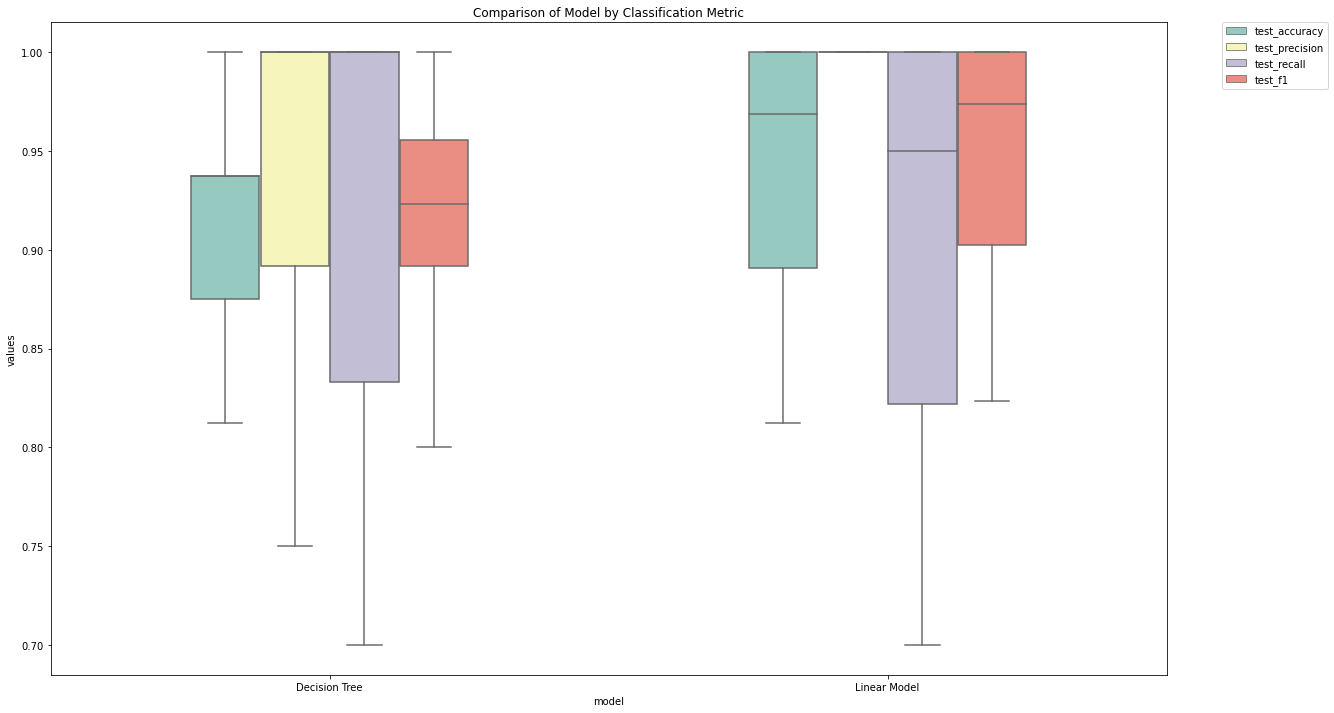

In [12]:
# Pivot the data frame to get long format
results_long = pd.melt(results, id_vars=['model'], var_name='metrics', value_name='values')

plt.figure(figsize=(20, 12))
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long, palette="Set3", width=.5, whis=10.)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')

We need to pick a metric to base our comparison. Reminder, $f1$ score is the harmonic mean of precision and recall. Typically, we can choose between accuracy and $f1$ score.
- accuracy: balanced dataset (no class dominating)
- $f1$ score: imbalanced dataset

Of course, this is more nuanced in practice and there are situations where other metrics should be used. 

In our case, both metrics are higher on average for the linear (logistic) model.

## <br><span style="color:teal"> Evaluate the final performance score
    
### <br><span style="color:blue"> Practice

Retrain the logistic model on the entire train set and compute the final performance score using the test set. 
    
Reminder: you can use the classification_report function (from sklearn.metrics) to get these scores. You can refer to the Decision Tree notebook to see how it is used.

In [13]:
model_logistic.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor', Pipeline(steps=[('nan', SimpleImputer())])),
                ('regressor', LogisticRegression())])

In [15]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, model_logistic.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.92      0.96        12

    accuracy                           0.95        20
   macro avg       0.94      0.96      0.95        20
weighted avg       0.96      0.95      0.95        20



# <br><span style="color:purple"> Additional materials

### <br><span style="color:blue"> Use $k$-fold CV to tune hyperparameters
    
Tuning hyperparameters is essentially comparing performances of different model configurations. Suppose we want to tune the hyperparameter min_samples_leaf of decision tree. We can follow the same procedure of comparing two models. 
    
scikit-learn has a special module to automate this process. GridSearchCV takes a list of hyperparameters and their values and applies CV.

In [102]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('tree', DecisionTreeClassifier(criterion='gini'))])

To check what the model's hyperparameters are

In [103]:
model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'tree', 'preprocessor__memory', 'preprocessor__steps', 'preprocessor__verbose', 'preprocessor__nan', 'preprocessor__nan__add_indicator', 'preprocessor__nan__copy', 'preprocessor__nan__fill_value', 'preprocessor__nan__missing_values', 'preprocessor__nan__strategy', 'preprocessor__nan__verbose', 'tree__ccp_alpha', 'tree__class_weight', 'tree__criterion', 'tree__max_depth', 'tree__max_features', 'tree__max_leaf_nodes', 'tree__min_impurity_decrease', 'tree__min_impurity_split', 'tree__min_samples_leaf', 'tree__min_samples_split', 'tree__min_weight_fraction_leaf', 'tree__random_state', 'tree__splitter'])

What we want to tune is stored in the model as 'tree__min_samples_leaf'. Suppose we want to test the values (1,3,5,7,9). We need to create a dictionary with keys being the hyperparameter names. 

In [128]:
parameters = {'tree__min_samples_leaf': np.arange(1, 10, 2)}
parameters

{'tree__min_samples_leaf': array([1, 3, 5, 7, 9])}

In [137]:
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=5, n_repeats=6, random_state=0)

In [143]:
from sklearn.model_selection import GridSearchCV
tuning = GridSearchCV(model, parameters, cv=cv, scoring='accuracy')
tuning.fit(X_train, Y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=6, n_splits=5, random_state=0),
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('nan',
                                                         SimpleImputer())])),
                                       ('tree', DecisionTreeClassifier())]),
             param_grid={'tree__min_samples_leaf': array([1, 3, 5, 7, 9])},
             scoring='accuracy')

We can access the mean score, standard deviation and ranking.

In [145]:
results_tuning = pd.DataFrame(tuning.cv_results_)
results_tuning[['param_tree__min_samples_leaf', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_tree__min_samples_leaf,mean_test_score,std_test_score,rank_test_score
0,1,0.922917,0.050217,4
1,3,0.920833,0.058035,5
2,5,0.929167,0.061942,3
3,7,0.941667,0.060237,1
4,9,0.937500,0.066536,2


We can directly access the hyperparameter that is ranked the highest

In [146]:
tuning.best_estimator_.named_steps["tree"].min_samples_leaf

7

and the corresponding score.

In [147]:
tuning.best_score_

0.9416666666666667

### <br><span style="color:blue"> Practice

Retrain the decision tree model with the chosen hyperparameter using the entire train set and produce a classification report using the test set.